In [3]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 1.3 MB/s 


In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import cv2
import numpy as np
import time 
import mediapipe as mp
import dlib
import numpy as np
import glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score,GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from google.colab.patches import cv2_imshow

In [5]:
!unzip /content/drive/MyDrive/AFLW2000-3D.zip
mylist = [Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")]
mylist

Archive:  /content/drive/MyDrive/AFLW2000-3D.zip
   creating: AFLW2000/
   creating: AFLW2000/Code/
  inflating: AFLW2000/Code/DrawSolidHead.m  
  inflating: AFLW2000/Code/DrawTextureHead.m  
  inflating: AFLW2000/Code/main_show_without_BFM.m  
  inflating: AFLW2000/Code/main_show_with_BFM.m  
   creating: AFLW2000/Code/Mex/
  inflating: AFLW2000/Code/Mex/compile.m  
  inflating: AFLW2000/Code/Mex/Tnorm_Vnorm.h  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.cpp  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.mexw64  
   creating: AFLW2000/Code/ModelGeneration/
  inflating: AFLW2000/Code/ModelGeneration/ModelGenerate.m  
  inflating: AFLW2000/Code/ModelGeneration/model_info.mat  
  inflating: AFLW2000/Code/Model_Exp.mat  
  inflating: AFLW2000/Code/Model_Shape_Sim.mat  
  inflating: AFLW2000/Code/NormDirection.m  
  inflating: AFLW2000/Code/readme.txt  
  inflating: AFLW2000/Code/RotationMatrix.m  
  inflating: AFLW2000/Code/Tnorm_VnormC.mexw64  
  inflating: AFLW2000/image00002.jpg  
  in

['image00622',
 'image02203',
 'image04299',
 'image00611',
 'image01763',
 'image01373',
 'image03427',
 'image02514',
 'image04163',
 'image01061',
 'image02625',
 'image03774',
 'image01012',
 'image01149',
 'image01085',
 'image00427',
 'image01132',
 'image01033',
 'image01419',
 'image00101',
 'image02285',
 'image03968',
 'image04196',
 'image03862',
 'image01198',
 'image01682',
 'image01008',
 'image02450',
 'image03609',
 'image02449',
 'image00844',
 'image00937',
 'image02803',
 'image00233',
 'image02518',
 'image03024',
 'image00670',
 'image00108',
 'image00120',
 'image01496',
 'image01644',
 'image01922',
 'image03190',
 'image01042',
 'image01733',
 'image00761',
 'image03761',
 'image00850',
 'image02547',
 'image01312',
 'image02532',
 'image01649',
 'image00544',
 'image01302',
 'image04272',
 'image01986',
 'image02178',
 'image01785',
 'image01787',
 'image02073',
 'image02273',
 'image04344',
 'image03541',
 'image02936',
 'image02488',
 'image00374',
 'image019

In [6]:
# X_points, Y_points, labels and detected files which are the images thar MediaPipe was able to detect the face  
X_points = []
Y_points = []
labels = []
detected_files = [] #conseder the detect image

# extracting the file names (2000 name)
file_names = sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")]) #سواء كانت ماتلات او الصوره العاديه 

# detecting faces and extracting the points
faceModule = mp.solutions.face_mesh
# looping over the file names to load the images and their corresponding mat file to get the point that we want
for filename in file_names:
  with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+filename+'.jpg')
    # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
          # appending the file names where have been detected.
          detected_files.append(filename)
          # detecting the face
          face = results.multi_face_landmarks[0]
          # initializing two lists to store the points for the image.
          X = []
          Y = []
          # looping over the 468 points of x and y
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image.
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # X_features
              X.append(relative_x)
              # Y_features
              Y.append(relative_y)

          # converting the lists to numpy arrays
          X = np.array(X)
          Y = np.array(Y)
          # appending the points of the images in the list of all image points
          X_points.append(X)
          Y_points.append(Y)

          # loading the mat file to extract the labels (pitch,yaw,roll)
          mat_file = sio.loadmat('/content/AFLW2000/'+filename+'.mat')
          # extracting the labels 3 angels
          pose_para = mat_file["Pose_Para"][0][:3] # to get (rall , yaw , patch)
          # appending the 3 angels to labels list
          labels.append(pose_para)

# converting features and labels to 2D array
X_points = np.array(X_points)
Y_points = np.array(Y_points)
labels = np.array(labels)

# the first label (pitch)
pitch_label = labels[:,0]
# the first label (yaw)
yaw_label = labels[:,1]
# the first label (roll)
roll_label = labels[:,2]
print(X_points.shape)
print(Y_points.shape)
print(labels.shape)

(1853, 468)
(1853, 468)
(1853, 3)


In [8]:
# normalizing the data
# center 100
# point1 = 19
# point2 = 180
# centering the data arround the 100th point 
Center_X = X_points - X_points[:,100].reshape(-1,1)
Center_Y = Y_points - Y_points[:,100].reshape(-1,1)

# normalizing the data to be in the same scale by dividing over the distance between point 19 and point 180
X_180 = X_points[:,180]
X_19 = X_points[:,19]
Y_180 = Y_points[:,180]
Y_19 = Y_points[:,19]
# computing the distance
distance = np.linalg.norm(np.array((X_19,Y_19)) - np.array((X_180,Y_180)),axis = 0).reshape(-1,1)
Norm_X = Center_X / distance
Norm_Y = Center_Y / distance

# if you want to choose specific columns from the data
Final_X = Norm_X
Final_Y = Norm_Y

print(Final_X.shape)
print(Final_Y.shape)

# concatinating the X and Y points to form the compelete features
features = np.hstack([Final_X,Final_Y])
print(features)

(1853, 468)
(1853, 468)
[[ 0.62299182  0.66749124  0.66749124 ... -0.35599533 -0.64524153
  -0.73424036]
 [-0.28111277 -0.62469505 -0.18740851 ... -0.49975604 -0.68716455
  -0.78086881]
 [ 0.81461828  0.85749293  0.81461828 ... -0.42874646 -0.64311969
  -0.68599434]
 ...
 [ 0.41216787  0.58571224  0.49894005 ... -0.19523741 -0.13015827
  -0.19523741]
 [ 0.82039817  0.91984037  0.87011927 ... -0.44748991 -0.69609541
  -0.77067707]
 [ 0.74904311  0.7287987   0.70855429 ... -0.52635461 -0.66806547
  -0.74904311]]


In [9]:
# splitting the data
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val,file_train,file_test = train_test_split(features,labels,detected_files,test_size = 0.2,random_state = 20)
y_train_pitch = y_train[:,0]
y_train_yaw = y_train[:,1]
y_train_roll = y_train[:,2]
y_val_pitch = y_val[:,0]
y_val_yaw = y_val[:,1]
y_val_roll = y_val[:,2]

In [11]:
xg_parameters = {'n_estimators': np.arange(7,15,2),'max_depth': np.arange(1,10,2),'learning_rate': np.arange(0.5,1,0.2)}
# grid search pitch
xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_pitch = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_pitch.fit(X_train, y_train_pitch)
xg_winner_pitch = xg_gs_pitch.best_estimator_
print("Pitch pest Model: ",xg_winner_pitch)
print("Train Error: ",mean_absolute_error(xg_winner_pitch.predict(X_train),y_train_pitch))
print("Validation Error: ",mean_absolute_error(xg_winner_pitch.predict(X_val),y_val_pitch))

Pitch pest Model:  XGBRegressor(learning_rate=0.5, max_depth=9, n_estimators=9, verbosity=0)
Train Error:  0.0395888551011774
Validation Error:  0.1185021172315284


In [12]:
# grid search yaw
xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_yaw = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_yaw.fit(X_train, y_train_yaw)
xg_winner_yaw = xg_gs_yaw.best_estimator_
print("Yaw Winner Model: ",xg_winner_yaw)
print("Train Error: ",mean_absolute_error(xg_winner_yaw.predict(X_train),y_train_yaw))
print("Validation Error: ",mean_absolute_error(xg_winner_yaw.predict(X_val),y_val_yaw))

Yaw Winner Model:  XGBRegressor(learning_rate=0.5, n_estimators=7, verbosity=0)
Train Error:  0.07897977961763118
Validation Error:  0.10073961356009616


In [13]:
# grid search roll
xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_roll = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_roll.fit(X_train, y_train_roll)
xg_winner_roll = xg_gs_roll.best_estimator_
print("Yaw Winner Model: ",xg_winner_roll)
print("Train Error: ",mean_absolute_error(xg_winner_roll.predict(X_train),y_train_roll))
print("Validation Error: ",mean_absolute_error(xg_winner_roll.predict(X_val),y_val_roll))

Yaw Winner Model:  XGBRegressor(learning_rate=0.5, n_estimators=9, verbosity=0)
Train Error:  0.0667765631316048
Validation Error:  0.09177035788916499


In [14]:
svr_parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'C':[0.01,0.1,1,10,100]}
# grid search pitch
svr = SVR()
svr_gs_pitch = GridSearchCV(estimator = svr,param_grid = svr_parameters)
svr_gs_pitch.fit(X_train, y_train_pitch)
svr_winner_pitch = svr_gs_pitch.best_estimator_
print("Pitch Winner Model: ",svr_winner_pitch)
print("Train Error: ",mean_absolute_error(svr_winner_pitch.predict(X_train),y_train_pitch))
print("Validation Error: ",mean_absolute_error(svr_winner_pitch.predict(X_val),y_val_pitch))

Pitch Winner Model:  SVR(C=10)
Train Error:  0.09580999279651194
Validation Error:  0.10187185983717448


In [15]:
# grid search yaw
svr = SVR()
svr_gs_yaw = GridSearchCV(estimator = svr,param_grid = svr_parameters)
svr_gs_yaw.fit(X_train, y_train_yaw)
svr_winner_yaw = svr_gs_yaw.best_estimator_
print("Yaw Winner Model: ",svr_winner_yaw)
print("Train Error: ",mean_absolute_error(svr_winner_yaw.predict(X_train),y_train_yaw))
print("Validation Error: ",mean_absolute_error(svr_winner_yaw.predict(X_val),y_val_yaw))

Yaw Winner Model:  SVR(C=10)
Train Error:  0.07101710197881284
Validation Error:  0.07258909497835313


In [16]:
# grid search roll
svr = SVR()
svr_gs_roll = GridSearchCV(estimator = svr,param_grid = svr_parameters)
svr_gs_roll.fit(X_train, y_train_roll)
svr_winner_roll = svr_gs_roll.best_estimator_
print("Yaw Winner Model: ",svr_winner_roll)
print("Train Error: ",mean_absolute_error(svr_winner_roll.predict(X_train),y_train_roll))
print("Validation Error: ",mean_absolute_error(svr_winner_roll.predict(X_val),y_val_roll))

Yaw Winner Model:  SVR(C=10)
Train Error:  0.07712906681467269
Validation Error:  0.07989681123491207


In [17]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

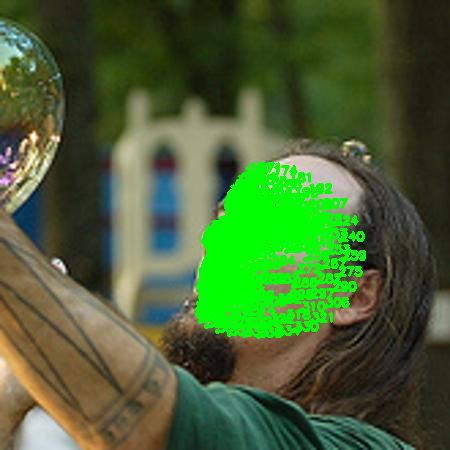

In [31]:
# choosing random image
random_file = random.choice(file_test)

faceModule = mp.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)


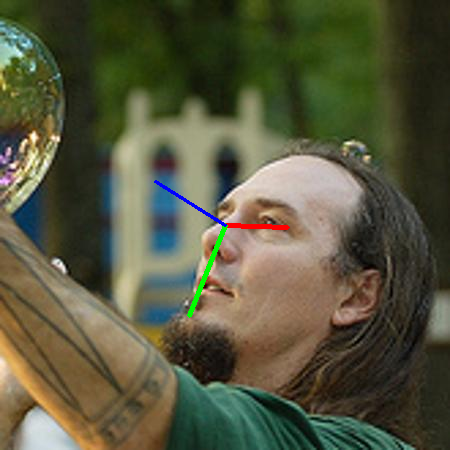

In [32]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))


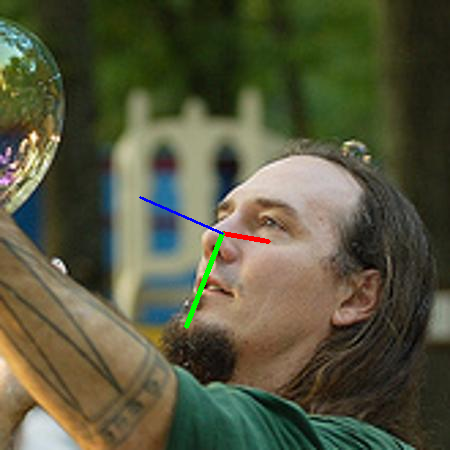

In [33]:
# choosing random image from the testing data
faceModule = mp.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread('/content/AFLW2000/' + random_file + '.jpg')
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # initializing two lists to store x and y points
        X = []
        Y = []
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            # getting the points back to its actual values
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            # appending the points to the X and Y lists
            X.append(relative_x)
            Y.append(relative_y)

        # converting the x and y points to numpy array
        X = np.array(X)
        Y = np.array(Y)

        # centering the points of x and y values arround the point no. 100
        X_center = X - X[100]
        Y_center = Y - Y[100]
        # computing the distance between the point 180 and 19
        d = np.linalg.norm(np.array((X[180],Y[180])) - np.array((X[19],Y[19])))
        # normalizing the points
        X_norm = X_center/d
        Y_norm = Y_center/d
        X_norm = X_norm
        Y_norm = Y_norm
        # concatinating the x and y points to predict the labels (pitch,yaw,roll)
        points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
        # predicting the 3 angels to draw the axis on the image
        pred_pitch = svr_winner_pitch.predict(points)
        pred_yaw = svr_winner_yaw.predict(points)
        pred_roll = svr_winner_roll.predict(points)
        cv2_imshow(draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[100],Y[100]))

In [34]:
class Queue:
    # defining the constructor
    def __init__(self,max_size):
        self.queue = []
        self.length = 0
        self.max_size = max_size
    
    # adding values to the queue
    def enqueue(self,x):
        if self.length < self.max_size:
          self.queue.append(x)
          self.length = self.length+1
        else:
          print("You have reached the maximum size") 
    # removing values from the queue
    def dequeue(self):
        if len(self.queue) > 0:
            removed = self.queue[0]
            del self.queue[0]
            self.length = self.length-1
            return removed
        else:
            print("Queue is Empty")

    # checking if the queue is full
    def IsFull(self):
      if self.length == self.max_size:
        return True
    
    # printing the queue values
    def print_queue(self):
        for i in self.queue:
            print(i)

In [58]:
# Create a VideoCapture object and read from input file
pitch_model=svr_winner_pitch
yaw_model=svr_winner_yaw
roll_model=svr_winner_roll
smoothing = False,
size = 30
cap = cv2.VideoCapture('/content/drive/MyDrive/stock-footage-man-turning-his-head-against-plain-background.webm')
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# initializing a list to store the frames   
img_array = []

# Check if video read successfully
if (cap.isOpened()== True): 
  pitch_queue = Queue(max_size = size)
  yaw_queue = Queue(max_size = size)
  roll_queue = Queue(max_size = size)
  # Read until video is completed
  while(cap.isOpened()):   
    # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True:
        with faceModule.FaceMesh(static_image_mode=True) as face:
          # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
          results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
          if results.multi_face_landmarks != None:
            for face in results.multi_face_landmarks:
                # initializing X and Y lists to store the spacial coordinates of the points
                X = []
                Y = []
                # looping over the landmarks to extract x and y
                for j,landmark in enumerate(face.landmark):
                    x = landmark.x
                    y = landmark.y
                    # retrieve the true values of x and y
                    shape = frame.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    X.append(relative_x)
                    Y.append(relative_y)

                X = np.array(X)
                Y = np.array(Y)
                # centering the data arround the point 100
                X_center = X - X[100]
                Y_center = Y - Y[100]
                d = np.linalg.norm(np.array((X[180],Y[180])) - np.array((X[19],Y[19])))
                X_norm = X_center/d
                Y_norm = Y_center/d
                X_norm = X_norm
                Y_norm = Y_norm
                points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
                # predicting the 3 angels to draw the axis on the image
                pred_pitch = pitch_model.predict(points)
                pred_yaw = yaw_model.predict(points)
                pred_roll = roll_model.predict(points)
                
                if smoothing  == True:
                  if not pitch_queue.IsFull(): 
                    pitch_queue.enqueue(pred_pitch)
                    yaw_queue.enqueue(pred_yaw)
                    roll_queue.enqueue(pred_roll)
                  else:
                    pitch_queue.dequeue()
                    yaw_queue.dequeue()
                    roll_queue.dequeue()
                    pitch_queue.enqueue(pred_pitch)
                    yaw_queue.enqueue(pred_yaw)
                    roll_queue.enqueue(pred_roll)

                  pitch = sum(pitch_queue.queue)/len(pitch_queue.queue)
                  yaw = sum(yaw_queue.queue)/len(yaw_queue.queue)
                  roll = sum(roll_queue.queue)/len(roll_queue.queue)
                  draw_axis(frame,pitch,yaw,roll,X[1],Y[1])

                else:
                  draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[1],Y[1])
                # appending the result frame to the img_array list
                img_array.append(frame)
      # Break the loop
      else: 
          break
cap.release()  
# Closes all the frames
cv2.destroyAllWindows()
# converting the frames to video
out = cv2.VideoWriter('out.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
for i in range(len(img_array)):
  out.write(img_array[i])
out.release()

In [61]:
from google.colab import files
files.download('/content/out.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>